In [105]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import rasterio
import pickle
import numpy as np

In [106]:
def read_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

In [107]:
trains = [{'channels': 8, 'pools': 1, 'layers': 8},
          {'channels': 8, 'pools': 1, 'layers': 32},
          {'channels': 8, 'pools': 1, 'layers': 64}
        ]

paths = {
  'T1': 'data/dataset/t1',
  'T2': 'data/dataset/t2',
  'mask': 'data/dataset/mask'
}

In [108]:
def read_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1).astype(np.float32)
        mask = np.nan_to_num(mask, nan=0.0)
        mask = np.where(mask > 0, 1.0, 0.0)
    return mask

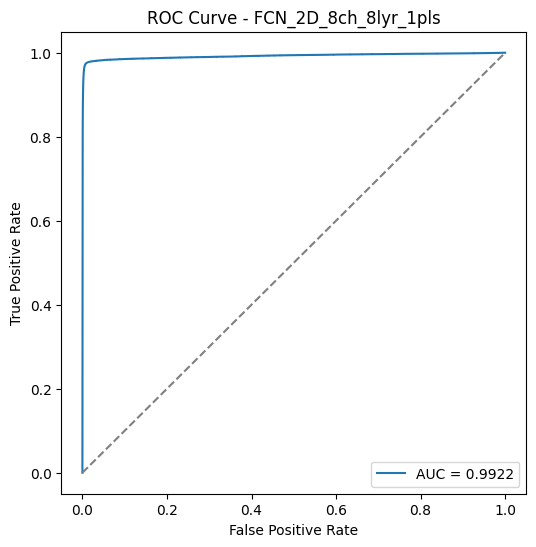

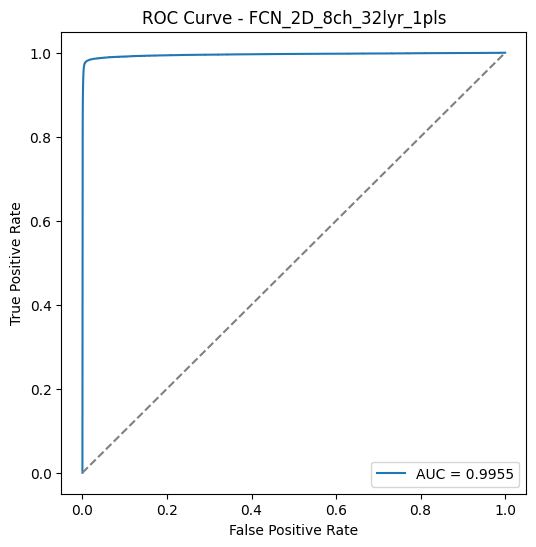

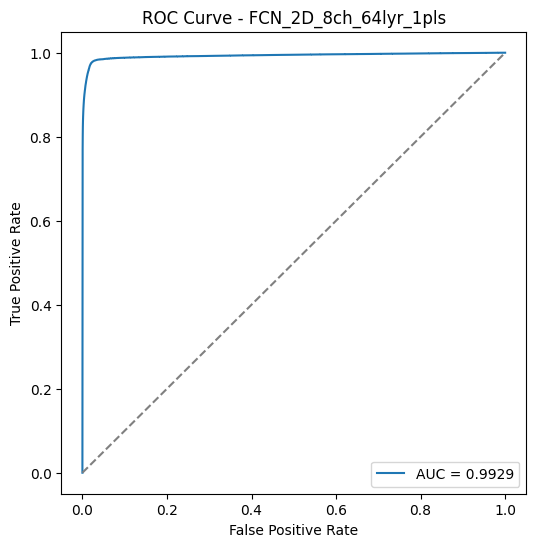

In [109]:
for train in trains:
    channels = train['channels']
    layers = train['layers']
    pools = train['pools']
    
    root_folder = os.getcwd()
    train_name = f'FCN_2D_{channels}ch_{layers}lyr_{pools}pls'
    file_path = os.path.join(root_folder, 'results', train_name, 'infer')

    split_paths = 'split_ids.csv'
    split_df = pd.read_csv(split_paths)
    val_ids = split_df[split_df['split'] == 'val']['ID'].tolist()

    all_labels = []
    all_preds = []

    for r in val_ids:
        mask = read_mask(os.path.join(paths['mask'], f'recorte_{r}.tif'))
        pickle_pred = read_pickle(os.path.join(file_path, f'recorte_{r}.pkl'))
        pred = np.array(pickle_pred).squeeze()
        
        # Flatten para usar no ROC
        all_labels.extend(mask.ravel())
        all_preds.extend(pred.ravel())

    labels = np.array(all_labels)
    preds = np.array(all_preds)
    auc = roc_auc_score(labels, preds)
    fpr, tpr, thresholds = roc_curve(labels, preds)

    # print(f"AUC-ROC: {auc:.4f}")

    # --- Plotar curva ROC ---
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {train_name}")
    plt.legend()
    plt.show()